# General Data Science Playground
## The kaggle dataset for predicting boston house prices can be found on https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

## 0 Import the required packages and external functions

### 0.1 Packages

In [90]:
# First import the required packages
from IPython.display import HTML
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn_pandas import DataFrameMapper
from sklearn_pandas import CategoricalImputer
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.base import TransformerMixin
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import seaborn as sns
pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline

## 0.2 Function for facilitating null value imputting

In [91]:
class DataFrameImputer(TransformerMixin):
    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype.name == "category" else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

## 1. Initial Prep of data
### 1. Read the files and check dimensions

In [92]:
# Read the files
test_data = pd.read_csv("test.csv")
train_data = pd.read_csv("train.csv")

# Get a brief view of the training data
print ("Train data shape:", train_data.shape)
print ("Test data shape:", test_data.shape)
print ("\nThe features are:", train_data.columns)
print ("\nThe data looks like this:\n", train_data.head())
train_data.describe()
n_train = train_data.shape[0]
n_test = test_data.shape[0]
n_comp = n_train+n_test
print("There are",n_train,"train samples and",n_test,"test samples")

target_Variable = "SalePrice"
##target_Variable = train_data.columns[-1]
print("The target variable is:" ,target_Variable)

Train data shape: (1460, 81)
Test data shape: (1459, 80)

The features are: Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish'

### 1.2 Combine copies of test and train for prep, seperate the target variable

In [93]:
# Seperate the target variable from the features
X_train, y_train = train_data.drop([target_Variable], axis = 1, inplace = False), train_data[target_Variable]
##X_train, y_train = train_data.iloc[:,:-1], train_data.iloc[:,-1]
 
# Compose a combination of test and train for the preprocessing part
X_test = test_data.copy()
X_train['is_train'] = 1
X_test['is_train'] = 0


assert X_test.shape[1]==X_train.shape[1], "Test and train data have different number of features!"
X_comp = pd.concat([X_train,X_test],axis=0,ignore_index=True)

# Verify that the ID columnn has unique values
assert X_comp.Id.nunique()==n_comp, "IDs are not unique" 

### 1.3 Basic understanding of the target variable

Skew is: 1.88287575977


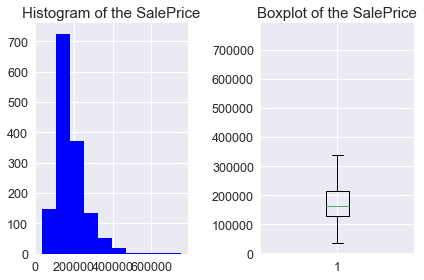

Skew is: 0.121346619897


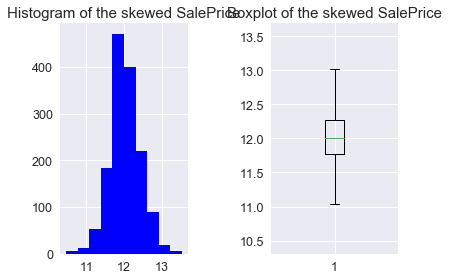

In [94]:
assert y_train.isnull().sum()==0, "There are missing values in the target variable"
if y_train.dtypes== object:
    y_train=y_train.astype('category')
    # Get the frequency of the categorical levels
    print(y_train.value_counts(dropna =False))
    # Convert Target Variable from text to 0 and 1
    ##y_train = y_train.map({'positive': 1, 'negative': 0})
    ##print(y_train.head())
else:
    print ("Skew is:", y_train.skew())
    plt.subplot(1,2,1)
    plt.hist(y_train, color='blue')
    plt.title("Histogram of the %s" %(target_Variable))

    plt.subplot(1,2,2)
    plt.boxplot(y_train)
    plt.title("Boxplot of the %s" %(target_Variable))

    plt.tight_layout()
    plt.show()
    
    if y_train.skew()>1:
        y_train = np.log1p(y_train)
        print ("Skew is:", y_train.skew())
        plt.subplot(1,2,1)
        plt.hist(y_train, color='blue')
        plt.title("Histogram of the skewed %s" %(target_Variable))

        plt.subplot(1,2,2)
        plt.boxplot(y_train)
        plt.title("Boxplot of the skewed %s" %(target_Variable))

        plt.tight_layout()
        plt.show()

### 1.4 Converting to correct format (categories)

In [95]:
# Check the type of features and convert objects to categorical
categorical_features = X_comp.select_dtypes(exclude=[np.number])
categorical_columns = categorical_features.columns.tolist()
for col in categorical_columns:
    X_comp[col]=X_comp[col].astype('category')
print("There are:",len(categorical_columns),"categorical features.\n ")
print(categorical_features.describe())

numeric_features = train_data.select_dtypes(include=[np.number])
numeric_columns = numeric_features.columns.tolist()

print("\n There are:",len(numeric_columns),"numeric features.\n ")
print(numeric_features.describe())

There are: 43 categorical features.
 
       MSZoning Street Alley LotShape LandContour Utilities LotConfig  \
count      2915   2919   198     2919        2919      2917      2919   
unique        5      2     2        4           4         2         5   
top          RL   Pave  Grvl      Reg         Lvl    AllPub    Inside   
freq       2265   2907   120     1859        2622      2916      2133   

       LandSlope Neighborhood Condition1      ...      GarageType  \
count       2919         2919       2919      ...            2762   
unique         3           25          9      ...               6   
top          Gtl        NAmes       Norm      ...          Attchd   
freq        2778          443       2511      ...            1723   

       GarageFinish GarageQual GarageCond PavedDrive PoolQC  Fence  \
count          2760       2760       2760       2919     10    571   
unique            3          5          5          3      3      4   
top             Unf         TA         T

## 2. EDA

### 2.1 Examine the correlation between numerical features and the target variable

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64 

BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


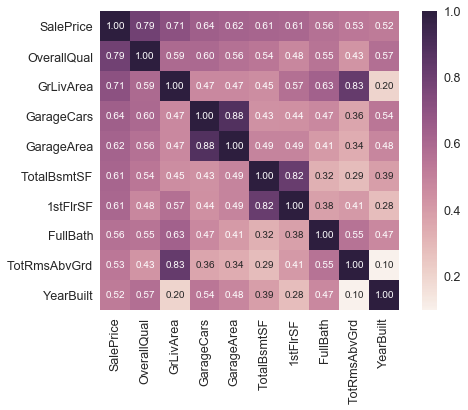

In [96]:
# Examine the correlation between numerical features
topX = 10 #top correlated features
corrmat = train_data.corr()
print (corrmat[target_Variable].sort_values(ascending=False)[:topX], '\n')
print (corrmat[target_Variable].sort_values(ascending=False)[-topX:])

#target_Variable correlation matrix
cols = corrmat.nlargest(topX, target_Variable)[target_Variable].index
cm = np.corrcoef(train_data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': topX}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

### 2.2 Visualize interesting correlations

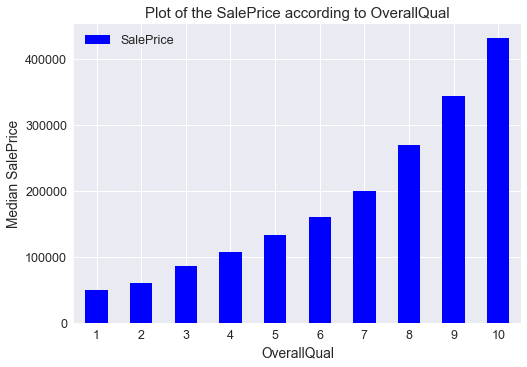

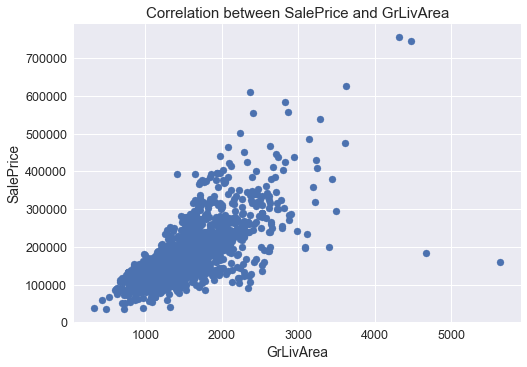

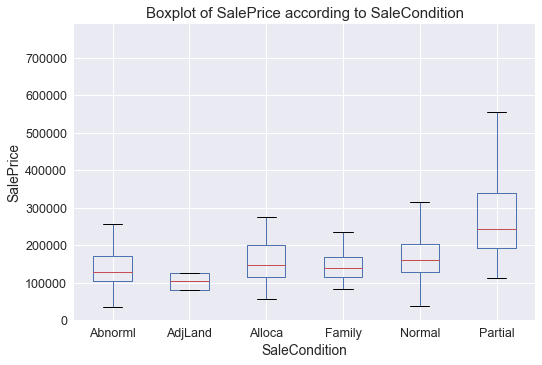

In [97]:
# A leveled numerical feature (category)
featureTemp='OverallQual'
quality_pivot = train_data.pivot_table(index=featureTemp,values=target_Variable, aggfunc=np.median)
quality_pivot.plot(kind='bar', color='blue')
plt.title("Plot of the %s according to %s" %(target_Variable,featureTemp))
plt.xlabel('%s' %(featureTemp))
plt.ylabel('Median %s' %(target_Variable))
plt.xticks(rotation=0)
plt.show()

# A "normal" numerical feature
featureTemp='GrLivArea'
plt.scatter(x=train_data[featureTemp], y=train_data[target_Variable])
plt.title("Correlation between %s and %s" %(target_Variable,featureTemp))
plt.ylabel('%s' %(target_Variable))
plt.xlabel('%s' %(featureTemp))
plt.show()

# A leveled numerical feature (category)
featureTemp='SaleCondition'
train_data.boxplot(column=target_Variable, by=featureTemp)
plt.title("Boxplot of %s according to %s" %(target_Variable,featureTemp))
plt.suptitle("")
plt.ylabel('%s' %(target_Variable))
plt.xlabel('%s' %(featureTemp))
plt.show()

### 2.3 Basic Outlier remover

In [98]:
# Simple outlier removal
print("The highest five prices are:\n",train_data[target_Variable].sort_values(ascending=False)[:5])
print("\n, whereas the 0.95 quantile:", train_data[target_Variable].quantile(0.95))

X_comp = X_comp[(X_comp['GrLivArea'] < 4000) | (X_comp.is_train==0)]
y_train = y_train[train_data['GrLivArea'] < 4000]

The highest five prices are:
 691     755000
1182    745000
1169    625000
898     611657
803     582933
Name: SalePrice, dtype: int64

, whereas the 0.95 quantile: 326099.99999999994


### 2.4 Examining Null Values

              Null Count  Null Percentage
Feature                                  
PoolQC              2907        99.725557
MiscFeature         2810        96.397942
Alley               2717        93.207547
Fence               2345        80.445969
FireplaceQu         1420        48.713551
LotFrontage          486        16.672384
GarageCond           159         5.454545
GarageYrBlt          159         5.454545
GarageFinish         159         5.454545
GarageQual           159         5.454545

Variable name: PoolQC
Type of the column: category
Number of nulls: 2907
Unique values are: Index(['Ex', 'Fa', 'Gd'], dtype='object')

Variable name: MiscFeature
Type of the column: category
Number of nulls: 2810
Unique values are: Index(['Gar2', 'Othr', 'Shed', 'TenC'], dtype='object')

Variable name: Alley
Type of the column: category
Number of nulls: 2717
Unique values are: Index(['Grvl', 'Pave'], dtype='object')

Variable name: Fence
Type of the column: category
Number of nulls: 2345
Un

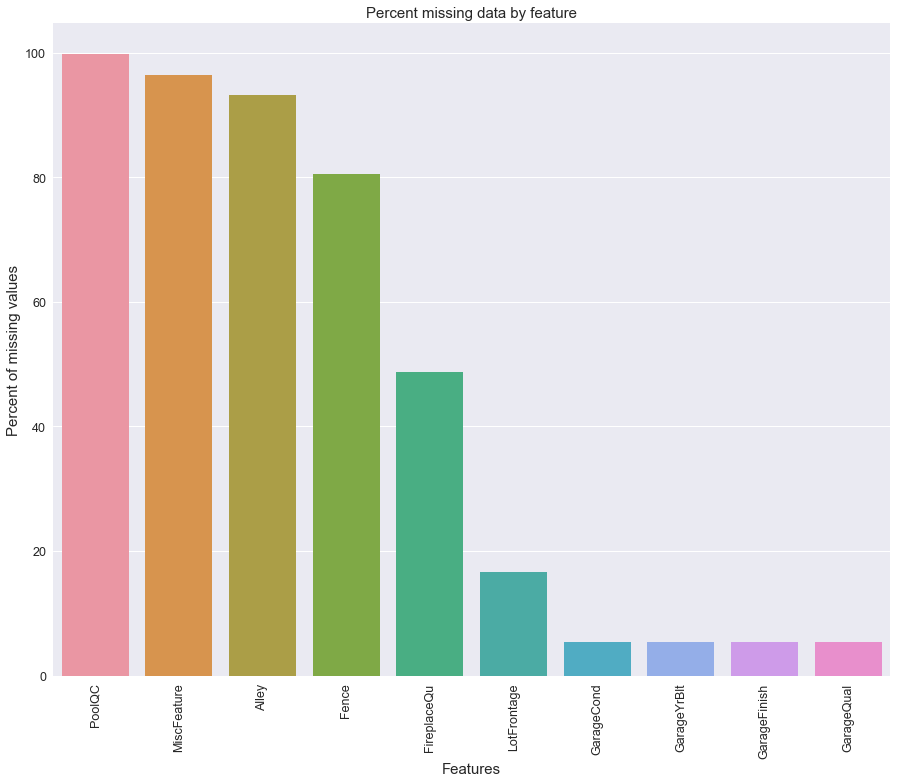

In [99]:
# Examine the topX columns with most null values
topX = 10
nulls = pd.DataFrame(X_comp.isnull().sum().sort_values(ascending=False)[:topX])
nulls_perc = (X_comp.isnull().sum() / len(X_comp)) * 100
nulls.columns = ['Null Count']
nulls['Null Percentage'] = nulls_perc
nulls.index.name = 'Feature'
print(nulls)

f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x = nulls_perc.sort_values(ascending=False)[:topX].index, y = nulls_perc.sort_values(ascending=False)[:topX])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

# Examine null values first way (in details)
nulls_per_column_train = X_train.isnull().sum().sort_values(ascending=False)
nulls_per_column_comp = X_comp.isnull().sum().sort_values(ascending=False)

for col in nulls_per_column_comp[nulls_per_column_comp>0].index:
    if nulls_per_column_comp[col]/(n_comp) - 0.1 > nulls_per_column_train[col]/(n_train):
        print("There are too many nulls in the test set for this feature!!!")
        print("Perc. nulls in complete set:",nulls_per_column_comp[col]/(n_comp),"Perc. nulls in train set:",nulls_per_column_train[col]/(n_train),"\n")
    if col in nulls_perc.sort_values(ascending=False)[:topX].index:
        print("\nVariable name:",col)
        print("Type of the column:",X_comp[col].dtypes)
        print("Number of nulls:",nulls_per_column_comp[col])
        if X_comp[col].dtype.name=="category":
            print("Unique values are:", X_comp[col].cat.categories)


### 2.5 Dealing with Null Values

In [100]:
# impute automatically (median or most-frequent)
listAuto=X_comp.select_dtypes(include=[np.number]).columns
X_comp[listAuto] = DataFrameImputer().fit_transform(X_comp[listAuto])
listAuto=["MasVnrArea","Utilities","BsmtQual"]
X_comp[listAuto] = DataFrameImputer().fit_transform(X_comp[listAuto])

# impute with 0
list0=["GarageArea","GarageCars"]
X_comp[list0] = X_comp[list0].fillna(0)

# impute with median
X_comp["MasVnrArea"] = X_comp.MasVnrArea.fillna(X_comp.MasVnrArea.median())

# impute with "Missing"
X_comp["GarageType"] = X_comp["GarageType"].cat.add_categories("Missing").fillna("Missing")
##X_comp["item_description"] = X_comp["item_description"].cat.add_categories("Missing").fillna("Missing")
##X_comp.loc[X_comp.item_description=='No description yet',['item_description']] = "Missing" 


## 3. Basic Feature Engineering
### 3.1 Modifying and creating features

A new column was created from GarageCond indicating if there is a GarageCond or not.

A new column was created from YearBuilt indicating how old a house is.

A new column was created from SaleCondition indicating if the value is Partial or not.


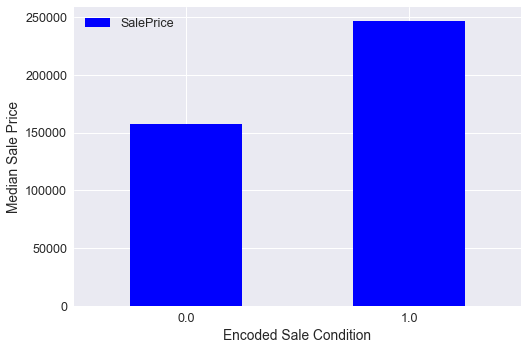

MSSubClass levels after grouping: 0    1529
1     699
2     687
Name: MSSubClass, dtype: int64
The following categorical features were successfully one hot encoded: 
 ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
('MSSubClass', 0.71114922813036019, 0.82280210964034661)
('LotFrontage', 69.128859613008842, 20.734841540758303)
('LotArea', 10133.648713550599, 7806.1985145054059)
('OverallQual', 6.0837049742710123, 1.4034441391477714)
('OverallCond', 5.56500857632933

In [101]:
# Quick and dirty...
##numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

##skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
##skewed_feats = skewed_feats[skewed_feats > 0.75]
##skewed_feats = skewed_feats.index
##all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

##all_data = pd.get_dummies(all_data)
##all_data = all_data.fillna(all_data.mean())

# First create a new dataframe which will include the new features.
featEng = X_comp.copy()

# create a new column indicating that it is missing
featureTemp = "GarageCond"
featEng['CompFeat_has_Garage'] = ~(featEng[featureTemp]=="Missing")
print("A new column was created from", featureTemp, "indicating if there is a", featureTemp, "or not.\n")

# Modify a column
featureTemp = "YearBuilt"
featEng["CompFeat_old"]=featEng[featureTemp].apply(lambda n : 2018-n)
print("A new column was created from", featureTemp, "indicating how old a house is.\n")
featEng.drop(featureTemp, axis = 1, inplace = True)

#Grouping all information about Garage in 3 types - good, bad , no
featEng['CompFeat_GarageQuality'] = (~featEng.GarageCond.isnull()).astype(int)
mean_Garea=featEng.GarageArea.mean()
list_Ggood=["Ex","Fa","Gd"]
goodGarageIndx = ((featEng.GarageFinish!="Unf")&(featEng.GarageArea>mean_Garea))
featEng.CompFeat_GarageQuality[goodGarageIndx]=2

#Create a feature with only two levels - the important one and the "others"
valueTemp = 'Partial'
featureTemp = "SaleCondition"
featEng['CompFeat_PartSaleCond'] = 1-~(featEng['SaleCondition']=='Partial')
print("A new column was created from", featureTemp, "indicating if the value is", valueTemp,"or not.")

condition_pivot = pd.concat([featEng[featEng.is_train==1],train_data.iloc[:,-1]],axis=1).pivot_table(index='CompFeat_PartSaleCond', values=target_Variable, aggfunc=np.median)
condition_pivot.plot(kind='bar', color='blue')
plt.xlabel('Encoded Sale Condition')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

# Bin numerical variables (like age or just grouping ordered numericals)
featureTemp = 'MSSubClass'
featEng[featureTemp] = pd.qcut(featEng[featureTemp], q=4, labels=False ,duplicates="drop")
print(featureTemp, "levels after grouping:",featEng[featureTemp].value_counts(dropna=False))

# One hot encoding features for all categorical, no need to fill miss values, no need to encode them
listOhe=[col for col in featEng if featEng[col].dtypes.name == "category"]
OheFeatures=pd.get_dummies(featEng[listOhe], prefix=listOhe, drop_first=True,dummy_na=True)
featEng = pd.concat([featEng, OheFeatures], axis=1);
print("The following categorical features were successfully one hot encoded: \n",listOhe)
featEng.drop(listOhe, axis=1, inplace = True)


# Encode categorical features (if using linear regression)
##listEnc = [col for col in featEng if featEng[col].dtypes.name == "category"]
##le = LabelEncoder()
##featEng[listEnc] = X_comp[listEnc].apply(lambda x: le.fit_transform(x.cat.add_categories("O").fillna('O')))
##[print(col, "was successfully encoded with", len(featEng[col].unique()),"levels") for col in listEnc ]


# Combine small sampled categories in "Others" 
# Note: the current implementation is far from optimal and rather slow...
##listGroup = listEnc
##for cat in listGroup:
##    if ((featEng[cat].value_counts(dropna=False)/n_comp)<0.01).sum()>1:
##        smallLevels = [level for level in featEng[cat].unique() if featEng[cat].value_counts(dropna=False)[int(level)]/n_comp <0.01]
##        newValue=featEng[cat].max()+1
##        for level in smallLevels:
##            featEng[cat].loc[lambda x : x == level] = newValue
##[print(col, "was successfully encoded with", len(featEng[col].unique()),"levels") for col in listGroup ]

# Standardize the other numerical variables
listToScale = [col for col in featEng if (featEng[col].dtypes.name != "uint8")&(col!='Id')&(col!="is_train")]
statsCol=zip(featEng[listToScale],featEng[listToScale].mean(),featEng[listToScale].std())
for stats in statsCol:
    print (stats)
listToScale = ['LotArea','MasVnrArea','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea']   
scaler = StandardScaler()                              
featEng[listToScale]=scaler.fit_transform(featEng[listToScale])

# Extract Title from Name, store in column and plot barplot
##data['Title'] = data.Name.apply(lambda x: re.search(' ([A-Z][a-z]+)\.', x).group(1))
##sns.countplot(x='Title', data=data);
##plt.xticks(rotation=45);


## 3.2 Text Features

In [1]:
# featFinal = featEng.copy()
tfv = TfidfVectorizer(min_df=3, max_features=None,
                      strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                      ngram_range=(1, 1), use_idf=1,smooth_idf=1,sublinear_tf=1,
                      stop_words = 'english')
tfvDesc = tfv.fit_transform(featFinal.item_description)
print(tfvDesc.shape)
tfvDesc_df = pd.DataFrame(tfvDesc.A, columns=tfv.get_feature_names())

svd = TruncatedSVD(n_components=50)
svdDesc = svd.fit_transform(tfvDesc)  # or tfvDesc_df
print(svdDesc_scl.shape)

scl = StandardScaler()
svdDesc_scl = scl.fit_transform(svdDesc)

nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(tfvDesc,y_train)

# Create the predicted tags: pred
pred = nb_classifier.predict(tfidf_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test,pred)
print(score)

# Calculate the confusion matrix: cm
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
print(cm)

# Get the class labels: class_labels
class_labels = nb_classifier.classes_

# Extract the features: feature_names
feature_names = tfidf_vectorizer.get_feature_names()

# Zip the feature names together with the coefficient array and sort by weights: feat_with_weights
feat_with_weights = sorted(zip(nb_classifier.coef_[0],feature_names))

# Print the first class label and the top 20 feat_with_weights entries
print(class_labels[0], feat_with_weights[:20])

# Print the second class label and the bottom 20 feat_with_weights entries
print(class_labels[1], feat_with_weights[-20:])

"\nfeatFinal = featEng.copy()\ntfv = TfidfVectorizer(min_df=3, max_features=None,\n                      strip_accents='unicode', analyzer='word',token_pattern=r'\\w{1,}',\n                      ngram_range=(1, 1), use_idf=1,smooth_idf=1,sublinear_tf=1,\n                      stop_words = 'english')\ntfvDesc = tfv.fit_transform(featFinal.item_description)\nprint(tfvDesc.shape)\ntfvDesc_df = pd.DataFrame(tfvDesc.A, columns=tfv.get_feature_names())\n\nsvd = TruncatedSVD(n_components=50)\nsvdDesc = svd.fit_transform(tfvDesc)  # or tfvDesc_df\nprint(svdDesc_scl.shape)\n\nscl = StandardScaler()\nsvdDesc_scl = scl.fit_transform(svdDesc)\n\nnb_classifier = MultinomialNB()\n\n# Fit the classifier to the training data\nnb_classifier.fit(tfvDesc,y_train)\n\n# Create the predicted tags: pred\npred = nb_classifier.predict(tfidf_test)\n\n# Calculate the accuracy score: score\nscore = metrics.accuracy_score(y_test,pred)\nprint(score)\n\n# Calculate the confusion matrix: cm\ncm = metrics.confusion_ma

### 3.2 Deleting old ones

In [104]:
#Drop unnecesary stuff
listDrop=[colName for colName in featEng.columns if (colName.find('Garage')>-1) & (colName.find('CompFeat')==-1)]
featEng.drop(listDrop, axis = 1, inplace = True)

## 4. Creating a Model
### 4.1 Define the training, test sets

In [105]:
# First get back to the training and test data
X_tr=featEng[featEng.is_train==1]
X_te=featEng[featEng.is_train==0]
X_tr.drop(["is_train","Id"], axis=1, inplace = True)
X_te.drop(["is_train","Id"], axis=1, inplace = True)

# Create a train/test set
test_size=.3
data_train, data_test, pred_train, pred_test = train_test_split(X_tr, y_train, random_state=1, test_size=test_size)
print("The train / test size ration is:",1-test_size,"/",test_size)

The train / test size ration is: 0.7 / 0.3


### 4.2 Create a LinearRegression with simple Cross Validation

In [106]:
# For classification problems, one typically uses stratified k-fold cross-validation
lr = linear_model.LinearRegression()
k = 3
cv_result = cross_val_score(lr,data_train, pred_train,scoring="neg_mean_squared_error",cv=k) # can be other scoring method R^2}(default),roc_auc, etc
print('CV Scores: ',cv_result)
print("Final RMSE:", np.mean(np.sqrt(np.abs(cv_result))))

CV Scores:  [-0.01644403 -0.01891741 -0.02465198]
Final RMSE: 0.140928109494


### 4.3 Knn with param tuning

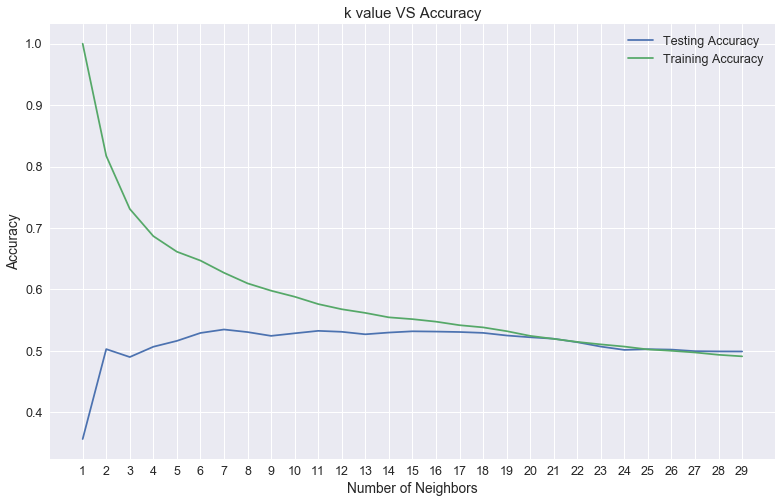

Best accuracy is 0.5348797716624014 with K = 7


In [107]:
neig = np.arange(1, 30)
train_accuracy = []
test_accuracy = []

for i, k in enumerate(neig):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn_model = knn.fit(data_train,pred_train)
    train_accuracy.append(knn_model.score(data_train, pred_train))
    test_accuracy.append(knn_model.score(data_test, pred_test))

plt.figure(figsize=[13,8])
plt.plot(neig, test_accuracy, label = 'Testing Accuracy')
plt.plot(neig, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.title('k value VS Accuracy')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.xticks(neig)
plt.show()
print("Best accuracy is {} with K = {}".format(np.max(test_accuracy),1+test_accuracy.index(np.max(test_accuracy))))

### 4.4 Simple Random Forest

Feature ranking for RandomForest:
1. OverallQual (0.536271)
2. GrLivArea (0.139126)
3. TotalBsmtSF (0.052062)
4. 1stFlrSF (0.049097)
5. CompFeat_old (0.028053)
6. BsmtFinSF1 (0.021124)
7. LotArea (0.019568)
8. YearRemodAdd (0.013041)
9. OverallCond (0.010329)
10. LotFrontage (0.010228)


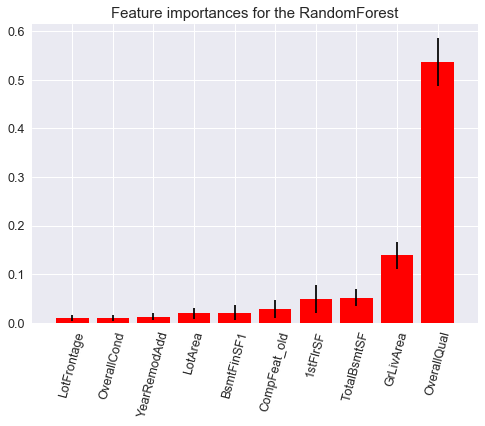

In [108]:
clf = RandomForestRegressor()
modelRF = clf.fit(data_train, pred_train)

    # Print the feature ranking
topX=10
importances = modelRF.feature_importances_
std = np.std([tree.feature_importances_ for tree in modelRF.estimators_],axis=0)
indices = np.argsort(importances)[-topX:]

print("Feature ranking for RandomForest:")
for f in np.arange(topX-1,-1,-1):
    print("%d. %s (%f)" % (topX-f, data_train.iloc[:,indices[f]].name, importances[indices[f]]))
    # Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances for the RandomForest")
plt.bar(range(topX), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(topX), data_train.iloc[:,indices].columns.tolist(),rotation=75)
plt.xlim([-1, topX])
plt.show()

### 4.5 Manually adjusting Lasso / Ridge the same but params in 10-100

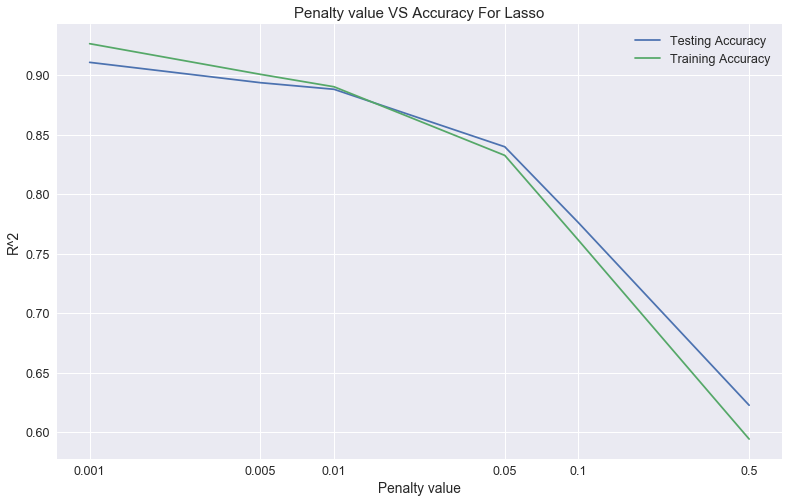

Lasso picked 75 variables and eliminated the other 194 variables
Feature ranking for Lasso:
1. GrLivArea (0.133921)
2. Neighborhood_Crawfor (0.093529)
3. CompFeat_PartSaleCond (0.086499)
4. Neighborhood_Somerst (0.065121)
5. OverallQual (0.063471)
6. Neighborhood_StoneBr (0.054815)
7. SaleCondition_Normal (0.053726)
8. MSZoning_RL (0.052382)
9. Functional_Typ (0.047561)
10. OverallCond (0.047521)


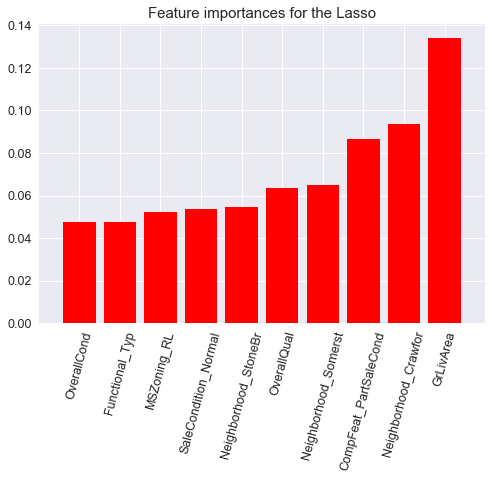

Best R^2 on train 0.9109103359174725 with alpha = 0.001
Lasso R^2 on test: 
 0.910910335917
Lasso RMSE on test: 
 0.0154114848742


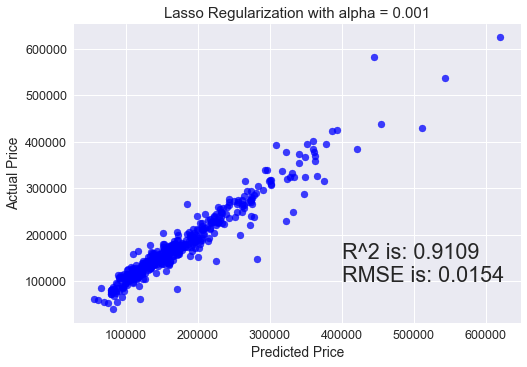

In [109]:
alphaValues = [0.001,0.005,0.01,0.05,0.1,0.5]
train_accuracy = []
test_accuracy = []
for i, alpha in enumerate(alphaValues):
    lm = linear_model.Lasso(alpha=alpha)
    lm.fit(data_train, pred_train)
    train_accuracy.append(lm.score(data_train, pred_train))
    test_accuracy.append(lm.score(data_test, pred_test))
bestAlpha = alphaValues[test_accuracy.index(np.max(test_accuracy))]

lasso = linear_model.Lasso(alpha=bestAlpha)
lasso.fit(data_train, pred_train)
lasso_pred = lasso.predict(data_test)
predictionsL = lasso.predict(X_te)

plt.figure(figsize=[13,8])
plt.semilogx(alphaValues, test_accuracy, label = 'Testing Accuracy')
plt.semilogx(alphaValues, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.title('Penalty value VS Accuracy For Lasso')
plt.xlabel('Penalty value')
plt.ylabel('R^2')
plt.xticks(alphaValues,alphaValues)
plt.show()

    # Print the feature ranking
topX=10
importances = lasso.coef_
print("Lasso picked " + str(sum(importances != 0)) + " variables and eliminated the other " +  str(sum(importances == 0)) + " variables")
indices = np.argsort(importances)[-topX:]

print("Feature ranking for Lasso:")
for f in np.arange(topX-1,-1,-1):
    print("%d. %s (%f)" % (topX-f, data_train.iloc[:,indices[f]].name, importances[indices[f]]))
    # Plot the feature importances of the Lasso
plt.figure()
plt.title("Feature importances for the Lasso")
plt.bar(range(topX), importances[indices], color="r", align="center")
plt.xticks(range(topX), data_train.iloc[:,indices].columns.tolist(),rotation=75)
plt.xlim([-1, topX])
plt.show()

print("Best R^2 on train {} with alpha = {}".format(np.max(test_accuracy),bestAlpha))
print ("Lasso R^2 on test: \n", lasso.score(data_test, pred_test))
print ('Lasso RMSE on test: \n', mean_squared_error(pred_test, lasso_pred))

plt.scatter(np.exp(lasso_pred), np.exp(pred_test), alpha=.75, color='b') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title("Lasso Regularization with alpha = {}".format(bestAlpha))
overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                    np.round(lasso.score(data_test, pred_test),4),
                    np.round(mean_squared_error(pred_test, lasso_pred),4))
plt.annotate(s=overlay,xy=(400000,100000),size='x-large') #xy cords are manually adjusted according to plot
plt.show()

### 4.6 Grid Search XGBRegressor 

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:   14.5s finished


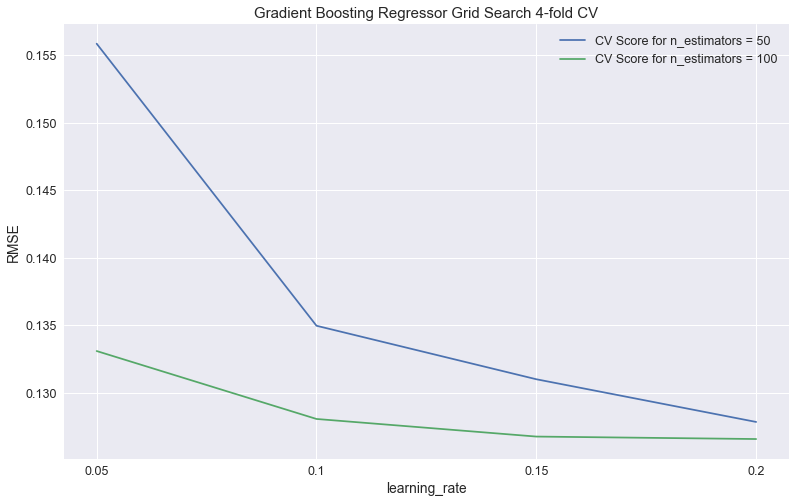

Lowest RMSE GBM on train:  0.126583099595
Best GBM parameters found:  {'learning_rate': 0.2, 'n_estimators': 100}
GBM RMSE on test: 0.13071960728257265
Feature ranking for GBM:
1. GrLivArea (0.063158)
2. OverallQual (0.057093)
3. CompFeat_old (0.056680)
4. TotalBsmtSF (0.055013)
5. LotArea (0.047037)
6. YearRemodAdd (0.032383)
7. 1stFlrSF (0.031152)
8. BsmtUnfSF (0.030004)
9. MoSold (0.029947)
10. OverallCond (0.029372)


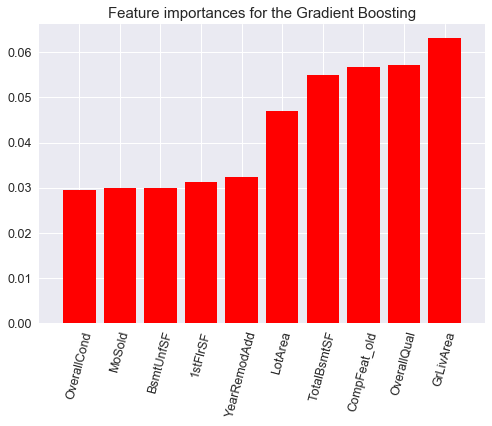

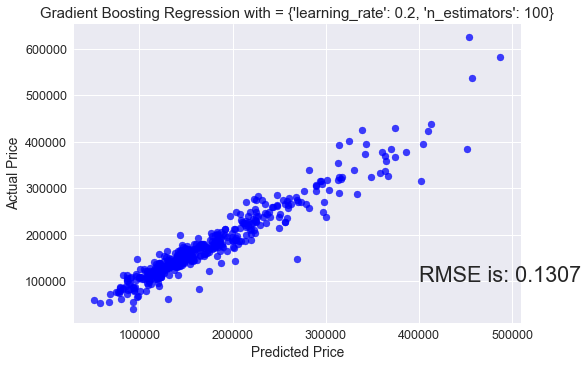

In [110]:
gbm_param_grid = {'learning_rate': [0.05,0.1,0.15,0.2], 'n_estimators': [50,100]}
gbm = GradientBoostingRegressor()
grid_gbm = GridSearchCV(estimator=gbm,param_grid=gbm_param_grid,scoring='neg_mean_squared_error', cv=4, verbose=1)
grid_gbm.fit(data_train, pred_train)

plt.figure(figsize=[13,8])
plt.plot(gbm_param_grid.get('learning_rate'), np.sqrt(np.abs(grid_gbm.cv_results_['mean_test_score'][::2])), label = 'CV Score for n_estimators = {}'.format(gbm_param_grid.get('n_estimators')[0]))
plt.plot(gbm_param_grid.get('learning_rate'), np.sqrt(np.abs(grid_gbm.cv_results_['mean_test_score'][1::2])), label = 'CV Score for n_estimators = {}'.format(gbm_param_grid.get('n_estimators')[1]))
plt.legend()
plt.title('Gradient Boosting Regressor Grid Search 4-fold CV')
plt.xlabel('{}'.format(list(gbm_param_grid.keys())[0]))
plt.ylabel('RMSE')
plt.xticks(gbm_param_grid.get('learning_rate'),gbm_param_grid.get('learning_rate'))
plt.show()
print("Lowest RMSE GBM on train: ", np.sqrt(np.abs(grid_gbm.best_score_)))
print("Best GBM parameters found: ",grid_gbm.best_params_)
print("GBM RMSE on test: {}".format(np.sqrt(np.abs(grid_gbm.score(data_test, pred_test)))))
    # Print the feature ranking
topX=10
importances = grid_gbm.best_estimator_.feature_importances_
indices = np.argsort(importances)[-topX:]

print("Feature ranking for GBM:")
for f in np.arange(topX-1,-1,-1):
    print("%d. %s (%f)" % (topX-f, data_train.iloc[:,indices[f]].name, importances[indices[f]]))
    # Plot the feature importances of the GBM
plt.figure()
plt.title("Feature importances for the Gradient Boosting")
plt.bar(range(topX), importances[indices], color="r", align="center")
plt.xticks(range(topX), data_train.iloc[:,indices].columns.tolist(),rotation=75)
plt.xlim([-1, topX])
plt.show()

gbm_pred=grid_gbm.predict(data_test)

plt.scatter(np.exp(gbm_pred), np.exp(pred_test), alpha=.75, color='b') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title("Gradient Boosting Regression with = {}".format(grid_gbm.best_params_))
overlay = 'RMSE is: {}'.format(
                    np.round(np.sqrt(mean_squared_error(pred_test, gbm_pred)),4))
plt.annotate(s=overlay,xy=(400000,100000),size='x-large') #xy cords are manually adjusted according to plot
plt.show()


## 5. Make the final predictions

In [111]:
predictionsGBM = grid_gbm.predict(X_te)
submission = pd.DataFrame()
submission['Id'] = X_test.Id
final_predictions = 0.5*np.expm1(predictionsGBM)+0.5*np.expm1(predictionsL)
submission['SalePrice'] = final_predictions
print(submission.head())
submission.to_csv('submission1.csv', index=False)


     Id      SalePrice
0  1461  115283.315858
1  1462  156926.779877
2  1463  192155.992436
3  1464  195597.925032
4  1465  196917.424992
